# High-Level Training Examples
In this notebook, we provide high-level training examples for training a Soft Actor-Critic (**SAC**) agent in the **RoboArmSim-v0** environment and a Twin Delayed Deep Deterministic (**TD3**) agent in the **WalkerSim-v0** environment.

In [1]:
from omegaconf import OmegaConf
from torchrl.envs.utils import step_mdp
from tqdm import tqdm
from environments import make_env
from src.agents import get_agent
from src.utils import (
    login,
    logout,
    prefill_buffer,
)


# 1. RoboArmSim Example 
## Training Parameter
Define training parameters for the agent and the environment and the general training loop:

In [2]:
# Agent configuration
agent_parameters = {
    "name": "sac",
    "lr": 3e-4,
    "batch_size": 256,
    "num_updates": 1,
    "prefill_episodes": 10,
    "num_cells": 256,
    "gamma": 0.99,
    "soft_update_eps": 0.995,
    "alpha_init": 1,
    "fixed_alpha": False,
    "loss_function": "l2",
    "normalization": "None",
    "dropout": 0.0,
    "prb": 0,
    "buffer_size": 1000000,
    "reset_params": False,
}

# Environment configuration
env_parameters = {
    "name": "roboarm_sim-v0",
    "max_episode_steps": 100,
    "verbose": 0,
    "frame_stack": 1,
    "action_filter": 1,
    "noise": 0.05,
    "reward_signal": "dense",
}
conf = OmegaConf.create({"run_name": "RoboArm-SAC-Example",
                         "device": "cuda",
                         "episodes": 200,
                         "agent": agent_parameters,
                         "env": env_parameters,})
print(OmegaConf.to_yaml(conf))

run_name: RoboArm-SAC-Example
device: cuda
episodes: 200
agent:
  name: sac
  lr: 0.0003
  batch_size: 256
  num_updates: 1
  prefill_episodes: 10
  num_cells: 256
  gamma: 0.99
  soft_update_eps: 0.995
  alpha_init: 1
  fixed_alpha: false
  loss_function: l2
  normalization: None
  dropout: 0.0
  prb: 0
  buffer_size: 1000000
  reset_params: false
env:
  name: roboarm_sim-v0
  max_episode_steps: 100
  verbose: 0
  frame_stack: 1
  action_filter: 1
  noise: 0.05
  reward_signal: dense



## Create Agent & Environment


In [3]:
# Create environment
env, action_space, state_space = make_env(conf)

# Make agent
agent, project_name = get_agent(action_space, state_space, conf)

# Loading agent weights or replay buffer
login(agent)

--- Agent initialized ---
Model not loaded!
Buffer not loaded!


## Prefill Replay Buffer
Prefill the replay buffer with random action transitions.

In [4]:
prefill_buffer(
    env=env,
    agent=agent,
    num_episodes=conf.agent.prefill_episodes,
)

Prefilling buffer:  20%|██        | 2/10 [00:00<00:00, 19.87it/s]

Prefill episode:  0
Prefill episode:  1
Prefill episode:  2
Prefill episode:  3
Prefill episode:  4
Prefill episode:  5


Prefilling buffer: 100%|██████████| 10/10 [00:00<00:00, 31.24it/s]

Prefill episode:  6
Prefill episode:  7
Prefill episode:  8
Prefill episode:  9
Prefill done! Buffer size:  673


## Training Loop

In [5]:
batch_size = conf.agent.batch_size
num_updates = conf.agent.num_updates
train_episodes = conf.episodes

# Lists for logging
rewards = []
final_errors = []
steps = []

for e in tqdm(range(train_episodes), desc="Training"):
    td = env.reset()
    done = td.get("done", False)
    truncated = td.get("truncated", False)
    ep_return = 0
    ep_steps = 0
    total_step_times = []

    while not done and not truncated:
        ep_steps += 1
        td = agent.get_action(td)
        td = env.step(td)
        agent.add_experience(td)
        done = td.get(("next", "done"), False)
        ep_return += td.get(("next", "reward"), 0)

        td = step_mdp(td)
        if done:
            break
    
    # Train the agent
    loss_info = agent.train(
        batch_size=batch_size, num_updates=num_updates * ep_steps
    )

    # Metrics Logging
    rewards.append(ep_return.item())
    steps.append(ep_steps)
    final_errors.append(td.get(("error"), 0).item())

# Save agent weights or replay buffer
logout(agent)
# Close environment
env.close()


Training: 100%|██████████| 200/200 [00:26<00:00,  7.56it/s]


## Plot Training Results

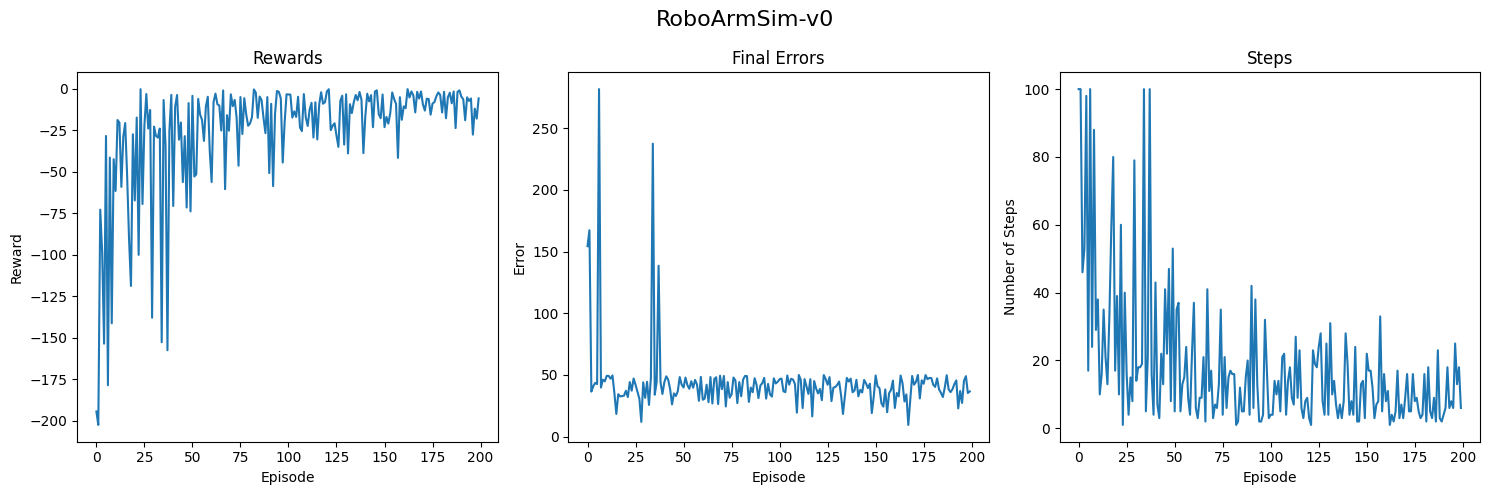

In [6]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot rewards
ax1.plot(rewards)
ax1.set_title('Rewards')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')

# Plot final errors
ax2.plot(final_errors)
ax2.set_title('Final Errors')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Error')

# Plot steps
ax3.plot(steps)
ax3.set_title('Steps')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Number of Steps')

# Set title
fig.suptitle('RoboArmSim-v0', fontsize=16)
plt.tight_layout()

plt.show()


# 2. WalkerSim Example
## Training Parameter
Define training parameters for the agent and the environment and the general training loop:

In [9]:
# Agent configuration
agent_parameters = {
    "name": "td3",
    "lr": 3e-4,
    "batch_size": 256,
    "num_updates": 1,
    "prefill_episodes": 10,
    "num_cells": 256,
    "gamma": 0.99,
    "soft_update_eps": 0.995,
    "loss_function": "smooth_l1",
    "normalization": "None",
    "dropout": 0.0,
    "prb": 0,
    "buffer_size": 1000000,
    "reset_params": False,
    "exploration_noise": 0.1,
}

# Environment configuration
env_parameters = {
    "name": "walker_sim-v0",
    "max_episode_steps": 100,
    "verbose": 0,
    "frame_stack": 1,
    "action_filter": 1,
    "noise": 0.1,
    "low_action_angle": -100,
    "high_action_angle": 0,
}
conf = OmegaConf.create(
    {
        "run_name": "WalkerSim-TD3-Example",
        "device": "cuda",
        "episodes": 200,
        "agent": agent_parameters,
        "env": env_parameters,
    }
)
print(OmegaConf.to_yaml(conf))


run_name: WalkerSim-TD3-Example
device: cuda
episodes: 200
agent:
  name: td3
  lr: 0.0003
  batch_size: 256
  num_updates: 1
  prefill_episodes: 10
  num_cells: 256
  gamma: 0.99
  soft_update_eps: 0.995
  loss_function: smooth_l1
  normalization: None
  dropout: 0.0
  prb: 0
  buffer_size: 1000000
  reset_params: false
  exploration_noise: 0.1
env:
  name: walker_sim-v0
  max_episode_steps: 100
  verbose: 0
  frame_stack: 1
  action_filter: 1
  noise: 0.1
  low_action_angle: -100
  high_action_angle: 0



## Create Agent & Environment


In [10]:
# Create environment
env, action_space, state_space = make_env(conf)

# Make agent
agent, project_name = get_agent(action_space, state_space, conf)

# Loading agent weights or replay buffer
login(agent)

--- Agent initialized ---
Model not loaded!
Buffer not loaded!


## Prefill Replay Buffer
Prefill the replay buffer with random action transitions.

In [11]:
prefill_buffer(
    env=env,
    agent=agent,
    num_episodes=conf.agent.prefill_episodes,
)

Prefilling buffer:  30%|███       | 3/10 [00:00<00:00, 22.21it/s]

Prefill episode:  0
Prefill episode:  1
Prefill episode:  2
Prefill episode:  3
Prefill episode:  4


Prefilling buffer:  90%|█████████ | 9/10 [00:00<00:00, 23.05it/s]

Prefill episode:  5
Prefill episode:  6
Prefill episode:  7
Prefill episode:  8
Prefill episode:  9


Prefilling buffer: 100%|██████████| 10/10 [00:00<00:00, 22.69it/s]

Prefill done! Buffer size:  1000


## Training Loop

In [12]:
batch_size = conf.agent.batch_size
num_updates = conf.agent.num_updates
train_episodes = conf.episodes

# For logging
rewards = []

for e in tqdm(range(train_episodes), desc="Training"):
    td = env.reset()
    done = td.get("done", False)
    truncated = td.get("truncated", False)
    ep_return = 0
    ep_steps = 0
    total_step_times = []

    while not done and not truncated:
        ep_steps += 1
        td = agent.get_action(td)
        td = env.step(td)
        agent.add_experience(td)
        done = td.get(("next", "done"), False)
        ep_return += td.get(("next", "reward"), 0)

        td = step_mdp(td)
        if done:
            break
    
    # Train the agent
    loss_info = agent.train(
        batch_size=batch_size, num_updates=num_updates * ep_steps
    )

    # Metrics Logging
    rewards.append(ep_return.item())


# Save agent weights or replay buffer
logout(agent)
# Close environment
env.close()


Training: 100%|██████████| 200/200 [02:04<00:00,  1.61it/s]


## Plot Training Results

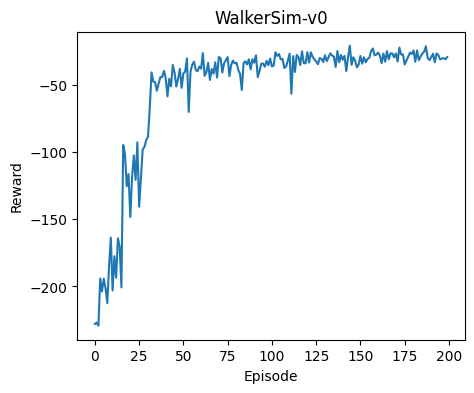

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 4))


# Plot rewards
ax.plot(rewards)
ax.set_title('WalkerSim-v0')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')

plt.show()
